In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import time
import pickle as pk
import matplotlib.pyplot as plt
import json
from glob import glob
from utils import plot_results
from math import ceil
from fisiocomPinn.Net import *
from fisiocomPinn.Trainer import *
from fisiocomPinn.Loss import *

# Definições iniciais

## Initializing Constants

In [2]:
# Opening JSON file
with open("control_dicts/constant_properties.json", "r") as openfile:
    # Reading from json file
    constant_properties = json.load(openfile)

Db = constant_properties["Db"]
Dn = constant_properties["Dn"]
phi = constant_properties["phi"]
cb = constant_properties["cb"]
lambd_nb = constant_properties["lambd_nb"]
mi_n = constant_properties["mi_n"]
lambd_bn = constant_properties["lambd_bn"]
y_n = constant_properties["y_n"]
Cn_max = constant_properties["Cn_max"]
X_nb = constant_properties["X_nb"]
central_ini_cond = constant_properties["central_ini_cond"]

# Opening JSON file
with open("control_dicts/mesh_properties.json", "r") as openfile:
    # Reading from json file
    mesh_properties = json.load(openfile)

h = mesh_properties["h"]
k = mesh_properties["k"]
x_dom = mesh_properties["x_dom"]
y_dom = mesh_properties["y_dom"]
t_dom = mesh_properties["t_dom"]

## Reading results file

In [3]:
def get_infection_site(struct_name):

    center_str = (struct_name).split("__")[-3].split("(")[-1].split(")")[0].split(",")

    center = (float(center_str[0]), float(center_str[1]))

    radius = float(struct_name.split("__")[-2].split("--")[-1].split(".pkl")[0])

    return center, radius


def read_files(path):
    file_list = sorted(glob(path + "/*"))

    speed_up_list = []
    Cl_list = []
    Cp_list = []

    for file in file_list:

        variable = lambda a: a.split("/")[-1].split("__")[0]

        if variable(file) == "Cl":
            Cl_list.append(file)

        elif variable(file) == "Cp":
            Cp_list.append(file)

        elif variable(file) == "speed_up":
            speed_up_list.append(file)

    return Cl_list, Cp_list, speed_up_list


def format_array(Cp_file, Cl_file):

    with open(Cp_file, "rb") as f:
        Cp = pk.load(f)

    with open(Cl_file, "rb") as f:
        Cl = pk.load(f)

    center, radius = get_infection_site(Cp_file)

    return Cp, Cl, center, radius

In [4]:
Cl_list, Cp_list, speed_up_list = read_files("fvm_sim")

Cp_fvm, Cl_fvm, center, radius = format_array(Cp_list[0], Cl_list[0])

## Formatting input parameters

In [5]:
def get_mesh_properties(
    x_dom,
    y_dom,
    t_dom,
    h,
    k,
    verbose=True,
):

    size_x = int(((x_dom[1] - x_dom[0]) / (h)))
    size_y = int(((y_dom[1] - y_dom[0]) / (h)))
    size_t = int(((t_dom[1] - t_dom[0]) / (k)) + 1)

    if verbose:
        print(
            "Steps in time = {:d}\nSteps in space_x = {:d}\nSteps in space_y = {:d}\n".format(
                size_t,
                size_x,
                size_y,
            )
        )

    return (size_x, size_y, size_t)

In [6]:
size_x, size_y, size_t = get_mesh_properties(x_dom, y_dom, t_dom, h, k)

Steps in time = 301
Steps in space_x = 40
Steps in space_y = 1



## Input verification

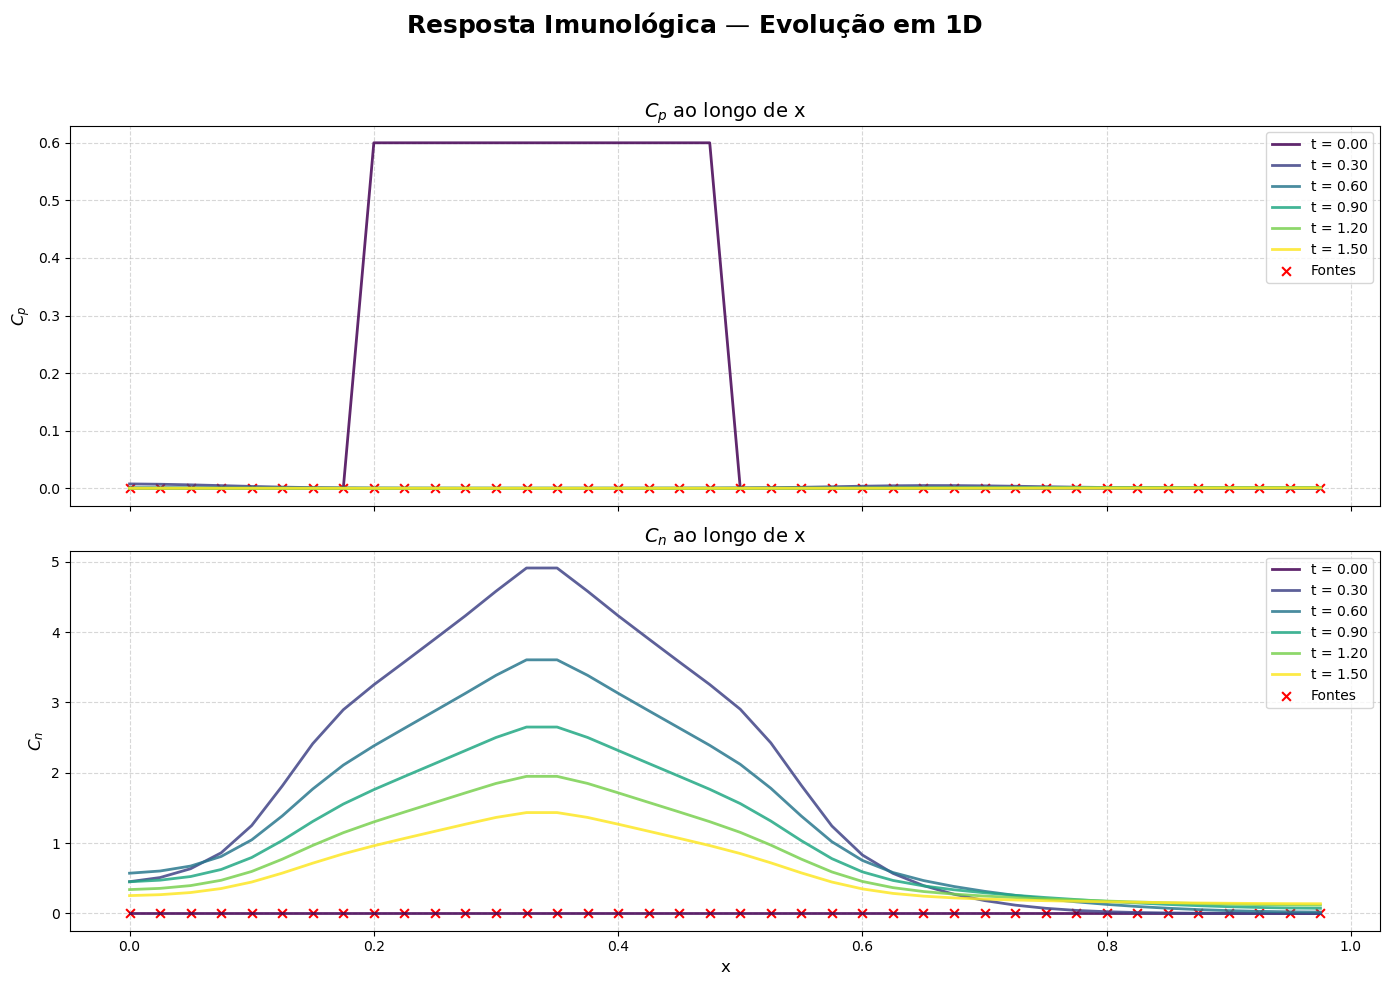

In [7]:
with open("source_points/lymph_vessels.pkl", "rb") as f:
    leu_source_points = pk.load(f)

plot_results(size_t, size_x, t_dom, x_dom, Cp_fvm, Cl_fvm, leu_source_points)

## Allocate GPU memmory

In [8]:
def under_sampling(n_samples, Cl, Cp):

    choosen_points = np.linspace(
        0, len(Cl) - 1, num=n_samples, endpoint=True, dtype=int
    )

    reduced_Cl = np.zeros((n_samples, Cl.shape[1], Cl.shape[2]))

    reduced_Cp = np.zeros((n_samples, Cp.shape[1], Cl.shape[2]))

    for i, idx in enumerate(choosen_points):

        reduced_Cl[i, :] = Cl[idx, :, :]

        reduced_Cp[i, :] = Cp[idx, :, :]

    return reduced_Cl, reduced_Cp, choosen_points

In [9]:
def create_input_mesh(
    source,
    t_dom,
    x_dom,
    size_t,
    size_x,
    Cl_fvm,
    Cp_fvm,
    n_samples=None,
):

    if len(source) == 2:
        source_index = np.argwhere(source[1][:, 0] == 1).ravel()

    else:
        source_index = np.argwhere(source[:, 0] == 1).ravel()

    x_np = np.linspace(
        x_dom[0], x_dom[-1], num=size_x, endpoint=False, dtype=np.float32
    )

    source_coordinates = x_np[source_index]

    if n_samples:

        reduced_Cl, reduced_Cp, choosen_points = under_sampling(
            n_samples, Cl_fvm, Cp_fvm
        )

        t_np = np.linspace(
            t_dom[0], t_dom[-1], num=size_t, endpoint=True, dtype=np.float32
        )[choosen_points]

        x_mesh, t_mesh = np.meshgrid(
            x_np,
            t_np,
        )

        return (
            reduced_Cl,
            reduced_Cp,
            t_mesh,
            x_mesh,
        )

    t_np = np.linspace(t_dom[0], t_dom[-1], num=size_t, endpoint=True, dtype=np.float32)

    x_mesh, t_mesh = np.meshgrid(
        x_np,
        t_np,
    )

    return (
        t_mesh,
        x_mesh,
        source_coordinates,
    )

In [10]:
def allocates_training_mesh(
    t_dom,
    x_dom,
    size_t,
    size_x,
    center_x,
    initial_cond,
    radius,
    Cl_fvm,
    Cp_fvm,
    source,
    n_samples=None,
):

    (
        t_mesh,
        x_mesh,
        src_coordinates,
    ) = create_input_mesh(
        source,
        t_dom,
        x_dom,
        size_t,
        size_x,
        Cl_fvm,
        Cp_fvm,
    )

    if torch.cuda.is_available():
        device = torch.device("cuda")

    else:
        device = "cpu"

    initial_tc = (
        torch.tensor(initial_cond, dtype=torch.float32)
        .reshape(-1, 1)
        .requires_grad_(True)
    )

    center_x_tc = (
        torch.tensor(center_x, dtype=torch.float32).reshape(-1, 1).requires_grad_(True)
    )

    radius_tc = (
        torch.tensor(radius, dtype=torch.float32).reshape(-1, 1).requires_grad_(True)
    )

    t_tc = torch.tensor(t_mesh, dtype=torch.float32).reshape(-1, 1)

    x_tc = torch.tensor(x_mesh, dtype=torch.float32).reshape(-1, 1)

    data_tc = torch.cat([t_tc, x_tc], dim=1).requires_grad_(True).to(device)

    src_tc = (
        torch.tensor(src_coordinates, dtype=torch.float32)
        .reshape(-1, 1)
        .requires_grad_(True)
    ).to(device)

    target = torch.tensor(
        np.array([Cl_fvm.flatten(), Cp_fvm.flatten()]).T,
        dtype=torch.float32,
    )

    if n_samples:

        (
            reduced_Cl,
            reduced_Cp,
            reduced_t_mesh,
            reduced_x_mesh,
        ) = create_input_mesh(
            source,
            t_dom,
            x_dom,
            size_t,
            size_x,
            Cl_fvm,
            Cp_fvm,
            n_samples,
        )

        reduced_t_tc = torch.tensor(reduced_t_mesh, dtype=torch.float32).reshape(-1, 1)

        reduced_x_tc = torch.tensor(reduced_x_mesh, dtype=torch.float32).reshape(-1, 1)

        reduced_data_tc = (
            torch.cat([reduced_t_tc, reduced_x_tc], dim=1)
            .requires_grad_(True)
            .to(device)
        )

        reduced_target = torch.tensor(
            np.array([reduced_Cl.flatten(), reduced_Cp.flatten()]).T,
            dtype=torch.float32,
        )

        return (
            initial_tc,
            center_x_tc,
            radius_tc,
            data_tc,
            src_tc,
            target,
            reduced_data_tc,
            reduced_target,
            device,
        )

    else:
        return (
            initial_tc,
            center_x_tc,
            radius_tc,
            data_tc,
            src_tc,
            target,
            device,
        )

In [11]:
n_samples = int(1204)
(
    initial_tc,
    center_x_tc,
    radius_tc,
    data_tc,
    src_tc,
    target,
    reduced_data_tc,
    reduced_target,
    device,
) = allocates_training_mesh(
    t_dom,
    x_dom,
    size_t,
    size_x,
    center[0],
    central_ini_cond,
    radius,
    Cp_fvm,
    Cl_fvm,
    leu_source_points,
    n_samples,
)

## Allocation validation

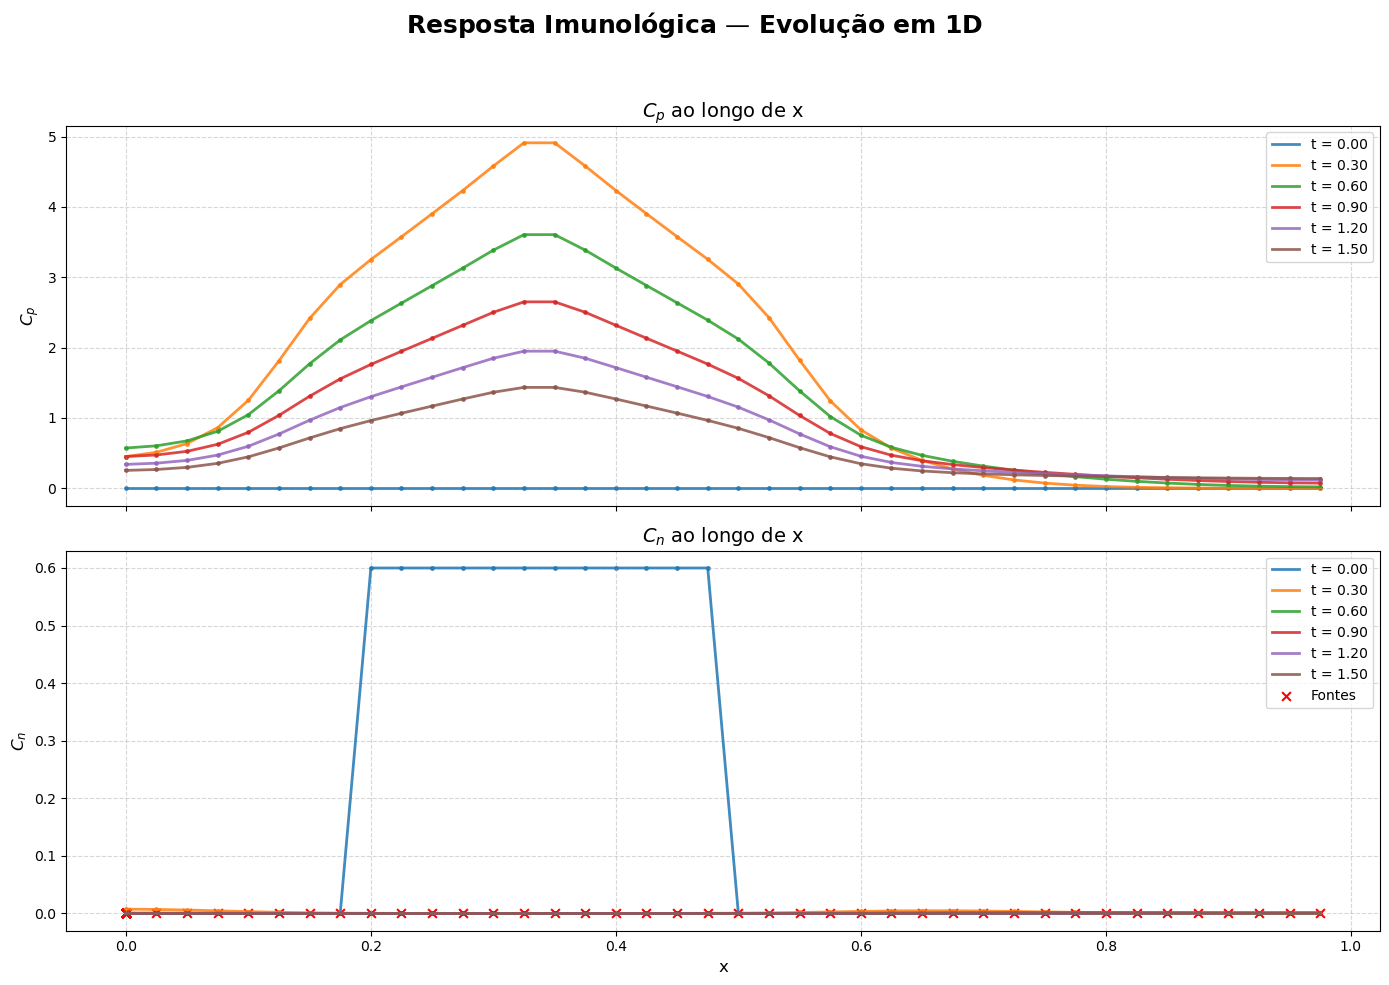

In [12]:
Cl_tc, Cp_tc = target.split(1, dim=1)

Cl = Cl_tc.cpu().detach().numpy().reshape(Cl_fvm.shape)
Cp = Cp_tc.cpu().detach().numpy().reshape(Cl_fvm.shape)

t_np = np.linspace(t_dom[0], t_dom[-1], num=size_t, endpoint=True, dtype=np.float32)
x_np = np.linspace(x_dom[0], x_dom[-1], num=size_x, endpoint=False, dtype=np.float32)

# t_np, x_np, Cp, Cl, source_index already defined
# source_index is assumed to be an array of x positions only (1D or Nx1)

time_plot = np.linspace(0, size_t - 1, num=6, endpoint=True, dtype=int)

fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

fig.suptitle(
    "$\\bf{Resposta\\ Imunológica}$ — Evolução em 1D", fontsize=18, weight="bold"
)

source_index = np.argwhere(leu_source_points == 1).ravel()


for i, time_inst in enumerate(time_plot):
    axes[0].plot(
        x_np,
        Cp[time_inst].squeeze(),
        label=f"t = {t_np[time_inst]:.2f}",
        linewidth=2,
        alpha=0.85,
    )

    time_ft = np.argwhere(
        data_tc[:, 0].cpu().detach().numpy() == t_np[time_inst]
    ).ravel()

    axes[0].scatter(
        data_tc[time_ft, 1].cpu().detach().numpy(),
        Cp_tc[time_ft].detach().numpy(),
        s=6,
        alpha=0.85,
    )

axes[0].set_title("$C_p$ ao longo de x", fontsize=14)
axes[0].set_ylabel("$C_p$", fontsize=12)
axes[0].legend()
axes[0].grid(True, linestyle="--", alpha=0.5)

# Plot Cl
for i, time_inst in enumerate(time_plot):
    axes[1].plot(
        x_np,
        Cl[time_inst].squeeze(),
        label=f"t = {t_np[time_inst]:.2f}",
        linewidth=2,
        alpha=0.85,
    )

    time_ft = np.argwhere(
        data_tc[:, 0].cpu().detach().numpy() == t_np[time_inst]
    ).ravel()

    axes[1].scatter(
        data_tc[time_ft, 1].cpu().detach().numpy(),
        Cl_tc[time_ft].detach().numpy(),
        s=6,
        alpha=0.85,
    )

axes[1].scatter(
    x_np[source_index],
    np.zeros((len(source_index))),
    color="red",
    label="Fontes",
    s=40,
    marker="x",
)

axes[1].set_title("$C_n$ ao longo de x", fontsize=14)
axes[1].set_xlabel("x", fontsize=12)
axes[1].set_ylabel("$C_n$", fontsize=12)
axes[1].legend()
axes[1].grid(True, linestyle="--", alpha=0.5)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Archtecture handling

In [13]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            torch.nn.init.zeros_(m.bias)

# PINN

n = 10  

# dois vetores crescentes
x1 = torch.linspace(-1, 1, n, requires_grad=True)
x2 = torch.linspace(-2, 2, n, requires_grad=True)


col1 = 2*x1**2 + 4*x1*x2 + 2*x2**2
col2 = (x1 - x2)**3

mat = torch.cat([col1.unsqueeze(1), col2.unsqueeze(1)], dim=1)

# conversão para numpy (para plotagem)
x1_np = x1.detach().numpy()
x2_np = x2.detach().numpy()

# criar grid para visualização de superfície
X1, X2 = np.meshgrid(x1_np, x2_np)
Z1 = (X1**2 + 2*X1*X2 + X2**2)
Z2 = ((X1 - X2)**3)

# plotar superfícies
fig = plt.figure(figsize=(12,5))

# Superfície quadrática
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(X1, X2, Z1, cmap="viridis", alpha=0.8)
ax1.set_title("Superfície Quadrática")
ax1.set_xlabel("x1")
ax1.set_ylabel("x2")
ax1.set_zlabel("f2(x1, x2)")

# Superfície cúbica
ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(X1, X2, Z2, cmap="plasma", alpha=0.8)
ax2.set_title("Superfície Cúbica")
ax2.set_xlabel("x1")
ax2.set_ylabel("x2")
ax2.set_zlabel("f3(x1, x2)")

plt.tight_layout()
plt.show()

# --- Gradientes ---
# derivadas da 1ª coluna em relação a x1 e x2
df1_dx1 = torch.autograd.grad(
    mat[:, 0], x1, grad_outputs=torch.ones_like(mat[:, 0]), retain_graph=True
)[0]
df1_dx2 = torch.autograd.grad(
    mat[:, 0], x2, grad_outputs=torch.ones_like(mat[:, 0]), retain_graph=True
)[0]

# derivadas da 2ª coluna em relação a x1 e x2
df2_dx1 = torch.autograd.grad(
    mat[:, 1], x1, grad_outputs=torch.ones_like(mat[:, 1]), retain_graph=True
)[0]
df2_dx2 = torch.autograd.grad(
    mat[:, 1], x2, grad_outputs=torch.ones_like(mat[:, 1]), retain_graph=True
)[0]

# converter para numpy
x1_np = x1.detach().numpy()
x2_np = x2.detach().numpy()

df1_dx1_np, df1_dx2_np = df1_dx1.detach().numpy(), df1_dx2.detach().numpy()
df2_dx1_np, df2_dx2_np = df2_dx1.detach().numpy(), df2_dx2.detach().numpy()

# --- Plotar ---
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

axes[0, 0].plot(x1_np, df1_dx1_np, "b")
axes[0, 0].set_title("∂f1/∂x1")

axes[0, 1].plot(x2_np, df1_dx2_np, "b")
axes[0, 1].set_title("∂f1/∂x2")

axes[1, 0].plot(x1_np, df2_dx1_np, "r")
axes[1, 0].set_title("∂f2/∂x1")

axes[1, 1].plot(x2_np, df2_dx2_np, "r")
axes[1, 1].set_title("∂f2/∂x2")

plt.tight_layout()
plt.show()

## Training

In [60]:
def generate_pde_points(num_points, device, t_upper):
    # Generate random (uniform) points in [0, 1) for time, x, and y
    t = torch.rand(num_points, 1, dtype=torch.float32) * t_upper

    x = torch.rand(num_points, 1, dtype=torch.float32)

    C = torch.zeros((len(x), 2), dtype=torch.float32)

    # Set requires_grad=True so we can compute PDE derivatives using autograd
    # Move each tensor to the specified device
    return (
        (t.requires_grad_(True).to(device), x.requires_grad_(True).to(device)),
        C.to(device),
    )


def generate_boundary_points(num_points, device, t_upper):

    t = torch.rand(num_points, 1, dtype=torch.float32) * t_upper

    x = (
        torch.tensor([0.0, 1], dtype=torch.float32)
        .repeat(num_points // 2, 1)
        .view(-1, 1)
    )

    C = torch.zeros((len(x), 2), dtype=torch.float32)

    return (
        (t.requires_grad_(True).to(device), x.requires_grad_(True).to(device)),
        C.to(device),
    )


def generate_initial_points(num_points, device, center_x_tc, radius_tc, initial_tc):
    t = torch.zeros(num_points, 1, dtype=torch.float32)

    x = torch.rand(num_points, 1, dtype=torch.float32)

    euclidean_distances = ((x - center_x_tc) ** 2) ** 0.5

    inside_circle_mask = euclidean_distances <= radius_tc

    C_init = torch.zeros((len(x), 2), dtype=torch.float32)

    C_init[:, 1] = inside_circle_mask.ravel() * initial_tc.ravel()

    return (
        (t.requires_grad_(True).to(device), x.requires_grad_(True).to(device)),
        C_init.to(device),
    )


def generate_pde_source(source_locs, h, batch, device):

    _, x_batch = batch  # [B, 1]

    # Identify active source locations in x_domain
    # source_locs = x_domain[original_source.view(-1) == 1]  # shape [M, 1], where M ≤ N

    # Compute bounds
    l_bound = source_locs - h  # [M, 1]
    u_bound = source_locs + h  # [M, 1]

    # Broadcast and check
    x_batch_exp = x_batch[:, None, :]  # [B, 1, 1]
    l_bound_exp = l_bound[None, :, :]  # [1, M, 1]
    u_bound_exp = u_bound[None, :, :]  # [1, M, 1]

    # Check if x_batch[i] is within any [l_bound[j], u_bound[j]]
    in_range = (x_batch_exp > l_bound_exp) & (x_batch_exp < u_bound_exp)  # [B, M, 1]
    match = in_range.any(dim=1)  # [B, 1]

    # Generate new source
    new_source = torch.zeros_like(x_batch).to(device)
    new_source[match] = 1.0

    # ---- DEBUG PRINTS ----
    # print("h:", h)
    # print("x_batch:", x_batch.shape)
    # print("x_domain:", x_domain.shape)
    # print("source_locs:", source_locs.shape)
    # print("l_bound:", l_bound.shape)
    # print("u_bound:", u_bound.shape)
    # print("x_batch_exp:", x_batch_exp.shape)
    # print("l_bound_exp:", l_bound_exp.shape)
    # print("u_bound_exp:", u_bound_exp.shape)
    # print("in_range:", in_range.shape)
    # print("match:", match.shape)
    # print("new_source:", new_source.shape)

    return new_source


def initial_condition(batch, model):
    t, x = batch

    input_data = torch.cat([t, x], dim=1).to(device)

    return model(input_data)


def boundary_condition(batch, model, Dn, X_nb, Db, device):

    t, x = batch

    input_data = torch.cat([t, x], dim=1).to(device)

    pred = model(input_data)

    n = (
        torch.tensor([-1, 1], dtype=torch.float32)
        .repeat(len(pred) // 2, 1)
        .requires_grad_(True)
        .view(-1, 1)
        .to(device)
    )

    dCl_dx = torch.autograd.grad(
        pred[:, 0],
        x,
        torch.ones_like(pred[:, 0]),
        create_graph=True,
        retain_graph=True,
    )[0]

    dCp_dx = torch.autograd.grad(
        pred[:, 1],
        x,
        torch.ones_like(pred[:, 1]),
        create_graph=True,
        retain_graph=True,
    )[0]

    Cl_boundary = Dn * dCl_dx * n - X_nb * torch.matmul(pred[:, 0].ravel(), dCp_dx * n)

    Cp_boundary = Db * dCp_dx * n

    # 4) Return them as one tensor, do NOT re-flag requires_grad
    return torch.cat([Cl_boundary, Cp_boundary], dim=1)


def pde(
    batch,
    model,
    h,
    cb,
    phi,
    lambd_nb,
    Db,
    y_n,
    Cn_max,
    lambd_bn,
    mi_n,
    Dn,
    X_nb,
    device,
    # source_locs,
):

    t, x = batch

    input_data = torch.cat([t, x], dim=1).to(device)

    pred = model(input_data)

    dCl_dx = torch.autograd.grad(
        pred[:, 0],
        x,
        torch.ones_like(pred[:, 0]),
        create_graph=True,
        retain_graph=True,
    )[0]

    dCp_dx = torch.autograd.grad(
        pred[:, 1],
        x,
        torch.ones_like(pred[:, 1]),
        create_graph=True,
        retain_graph=True,
    )[0]

    dCl_dt = torch.autograd.grad(
        pred[:, 0],
        t,
        torch.ones_like(pred[:, 0]),
        create_graph=True,
        retain_graph=True,
    )[0]

    dCp_dt = torch.autograd.grad(
        pred[:, 1],
        t,
        torch.ones_like(pred[:, 1]),
        create_graph=True,
        retain_graph=True,
    )[0]

    d2Cl_dx2 = torch.autograd.grad(
        dCl_dx,
        x,
        torch.ones_like(dCl_dx),
        create_graph=True,
        retain_graph=True,
    )[0]

    d2Cp_dx2 = torch.autograd.grad(
        dCp_dx,
        x,
        torch.ones_like(dCp_dx),
        create_graph=True,
        retain_graph=True,
    )[0]

    # Calculating Cl value

    # source = generate_pde_source(source_locs, h, batch, device)

    # qn = y_n * pred[:, 1:2] * (Cn_max - pred[:, 0:1]) * source  # [1000, 1]
    # rn = lambd_bn * pred[:, 0:1] * pred[:, 1:2] + mi_n * pred[:, 0:1]  # [1000, 1]

    # Cl_eq = (
    #     Dn * d2Cl_dx2 - X_nb * (pred[:, 1:2] * d2Cp_dx2 + dCl_dx * dCp_dx) - rn + qn
    # ) - dCl_dt * phi  # All shapes [1000, 1]

    # qb = cb * pred[:, 1:2]
    # rb = lambd_nb * pred[:, 0:1] * pred[:, 1:2]

    # Cp_eq = Db * d2Cp_dx2 - rb + qb - dCp_dt * phi  # All shapes [1000, 1]

    qn = y_n * pred[:, 1:2] * (Cn_max - pred[:, 0:1])  # [1000, 1]
    rn = lambd_bn * pred[:, 0:1] * pred[:, 1:2] + mi_n * pred[:, 0:1]  # [1000, 1]

    Cl_eq = (
        Dn * d2Cl_dx2 - X_nb * (pred[:, 1:2] * d2Cp_dx2 + dCl_dx * dCp_dx) - rn + qn
    ) - dCl_dt * phi  # All shapes [1000, 1]

    qb = cb * pred[:, 1:2]
    rb = lambd_nb * pred[:, 0:1] * pred[:, 1:2]

    Cp_eq = Db * d2Cp_dx2 - rb + qb - dCp_dt * phi  # All shapes [1000, 1]

    return torch.cat([Cl_eq, Cp_eq], dim=1)

In [65]:
dtype = torch.float64
model = (
    nn.Sequential(
        # Input layer: 1 -> 32 neurons, followed by Tanh activation
        nn.Linear(2, 32),
        nn.SiLU(),
        # Hidden layer: 32 -> 32 neurons
        nn.Linear(32, 32),
        nn.SiLU(),
        # Hidden layer: 32 -> 32 neurons
        nn.Linear(32, 32),
        nn.SiLU(),
        # Hidden layer: 32 -> 32 neurons
        nn.Linear(32, 32),
        nn.SiLU(),
        # Hidden layer: 32 -> 32 neurons
        nn.Linear(32, 32),
        nn.SiLU(),
        # Output layer: 32 -> 2 neurons (representing Cp and Cl)
        nn.Linear(32, 2),
    )
    .apply(init_weights)
    .apply(init_weights)
)
print(model)
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

Sequential(
  (0): Linear(in_features=2, out_features=32, bias=True)
  (1): SiLU()
  (2): Linear(in_features=32, out_features=32, bias=True)
  (3): SiLU()
  (4): Linear(in_features=32, out_features=32, bias=True)
  (5): SiLU()
  (6): Linear(in_features=32, out_features=32, bias=True)
  (7): SiLU()
  (8): Linear(in_features=32, out_features=32, bias=True)
  (9): SiLU()
  (10): Linear(in_features=32, out_features=2, bias=True)
)
4386


In [66]:
n_epochs = int(1e4)
batch_size = int(2.5e2)
beta1 = 0.825
beta2 = 0.99

optimizer = optim.Adam(model.parameters(), lr=1e-3)

trainer = Trainer(
    n_epochs=n_epochs,
    batch_size=batch_size,
    model=model,
    device=device,
    target=reduced_target,
    # data=reduced_data_tc,
    patience=2750,
    tolerance=0.01,
    validation=0.2,
    optimizer=optimizer,
    print_steps=1e3,
)

In [67]:
init_loss = LOSS(
    device=device,
    name="LossInital",
    batch_size=batch_size,
)

init_loss.setBatchGenerator(generate_initial_points, center_x_tc, radius_tc, initial_tc)

init_loss.setEvalFunction(
    initial_condition,
)

# trainer.add_loss(init_loss, 5)


bnd_loss = LOSS(
    device=device,
    name="LossBoundary",
    batch_size=batch_size,
)

bnd_loss.setBatchGenerator(generate_boundary_points, t_dom[1])

bnd_loss.setEvalFunction(boundary_condition, Dn, X_nb, Db, device)

trainer.add_loss(bnd_loss)


pde_loss = LOSS(
    device=device,
    name="LossPDE",
    batch_size=batch_size,
)

pde_loss.setBatchGenerator(generate_pde_points, t_dom[1])

pde_loss.setEvalFunction(
    pde, h, cb, phi, lambd_nb, Db, y_n, Cn_max, lambd_bn, mi_n, Dn, X_nb, device
)

trainer.add_loss(pde_loss)

In [68]:
model, loss_dict = trainer.train()

Iteration 0: total loss 0.8471, losses: [0.0008818887290544808, 0.8462286591529846], time: 0.0136s
Iteration 1000: total loss 0.0083, losses: [8.40330926621391e-07, 0.008285995572805405], time: 0.0101s
Iteration 2000: total loss 0.0236, losses: [1.9479525690258015e-06, 0.023589104413986206], time: 0.0095s
Iteration 3000: total loss 0.0162, losses: [1.4994483876762388e-07, 0.016228755936026573], time: 0.0102s
Iteration 4000: total loss 0.0035, losses: [4.554869903472536e-08, 0.003527431981638074], time: 0.0098s
Iteration 5000: total loss 0.0027, losses: [4.372419653009274e-07, 0.0026500211097300053], time: 0.0105s
Iteration 6000: total loss 0.0077, losses: [7.897758109720598e-07, 0.007672524079680443], time: 0.0105s
Iteration 7000: total loss 0.0031, losses: [2.2538360155976989e-07, 0.003071425249800086], time: 0.0097s
Iteration 8000: total loss 0.0039, losses: [5.4663363613371985e-08, 0.003892868757247925], time: 0.0093s
Iteration 9000: total loss 0.0087, losses: [8.738587098378048e-08

## Validation

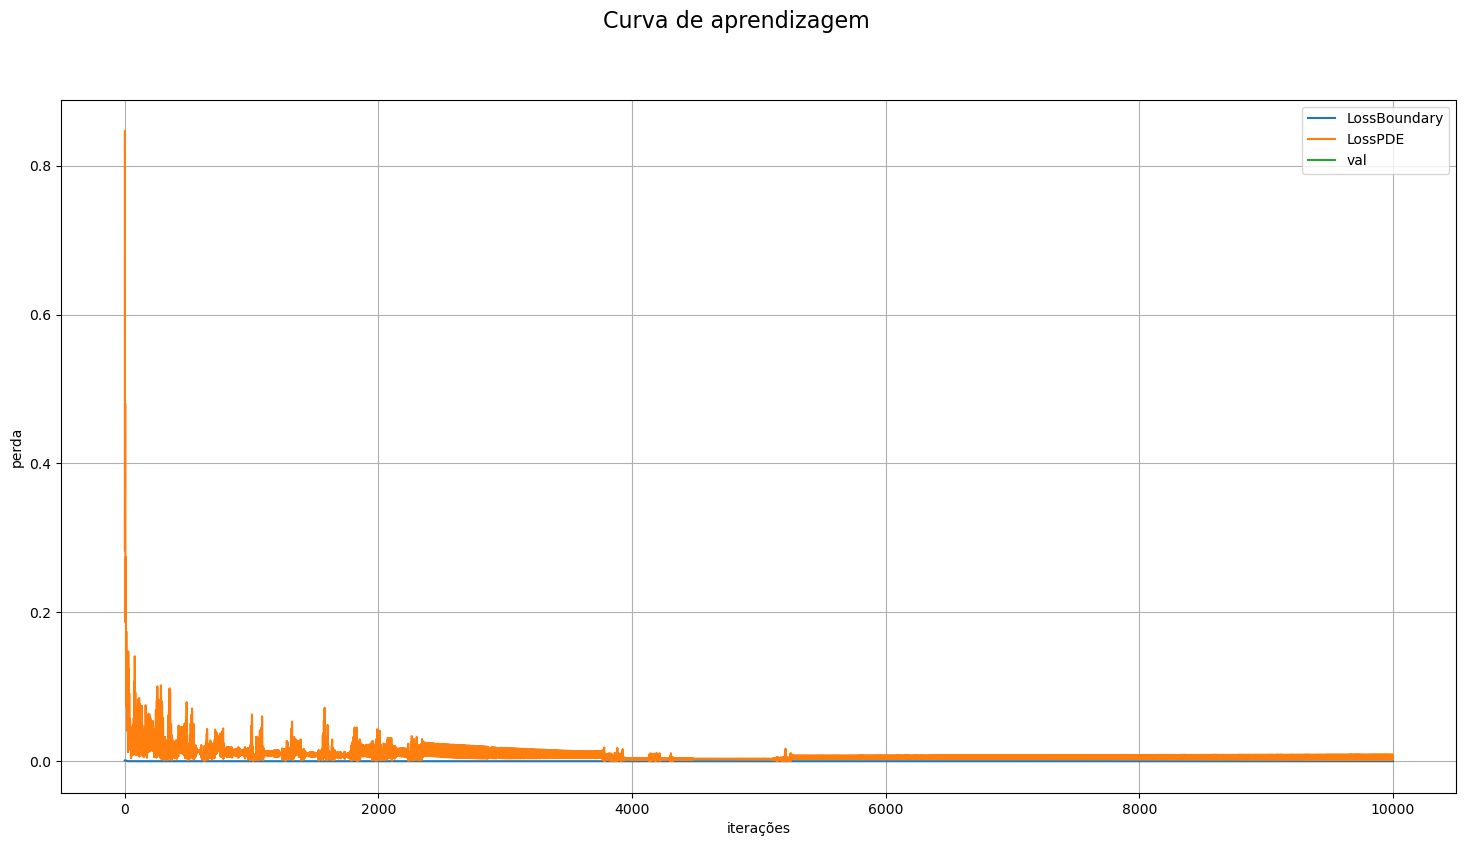

In [69]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=[18, 9])

fig.suptitle("Curva de aprendizagem", fontsize=16)

# Plotango 3D
ax = fig.add_subplot(1, 1, 1)

ax.set_xlabel("iterações")
ax.set_ylabel("perda")

for loss in loss_dict:
    ax.plot(
        range(len(loss_dict[loss])),
        loss_dict[loss],
        label=loss,
    )

# ax.set_yscale("log")
ax.grid()
ax.legend()

plt.show()

In [70]:
model = trainer.model

mesh = data_tc.to(device)

with torch.no_grad():
    pred_pinn_dev = model(mesh)

pred_pinn = pred_pinn_dev.cpu().detach().numpy()

In [71]:
Cl_pinn_device, Cp_pinn_device = pred_pinn_dev.split(1, dim=1)

Cl_pinn_np = Cl_pinn_device.cpu().detach().numpy().reshape(Cl_fvm.shape)
Cp_pinn_np = Cp_pinn_device.cpu().detach().numpy().reshape(Cl_fvm.shape)

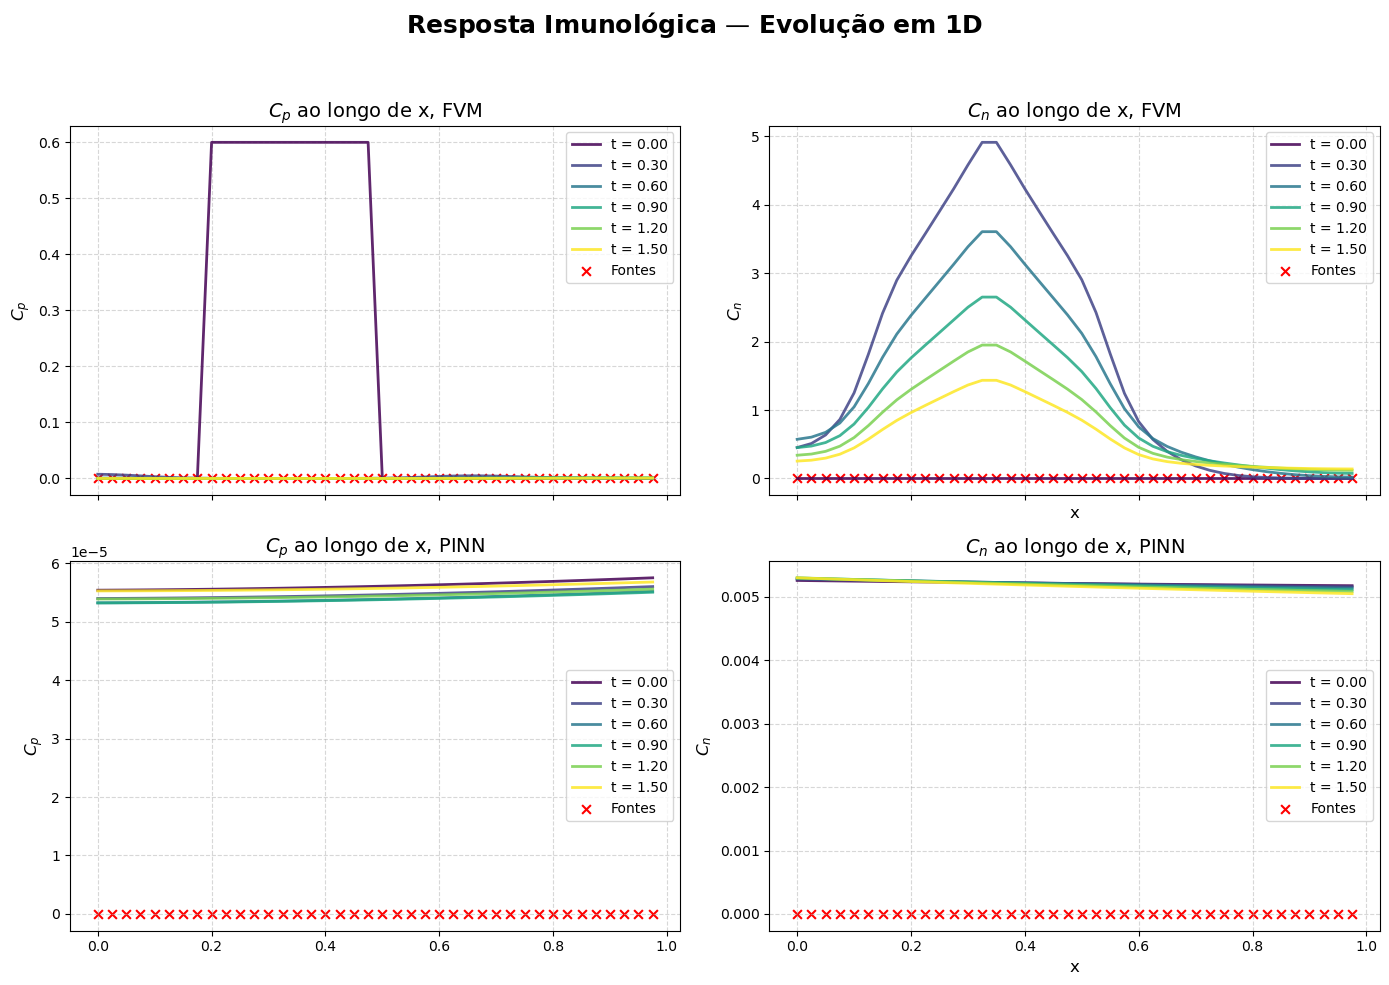

In [72]:
from utils import plot_comparison, animate_1D_comparison

plot_comparison(
    size_t,
    size_x,
    t_dom,
    x_dom,
    Cp_fvm,
    Cl_fvm,
    Cp_pinn_np,
    Cl_pinn_np,
    leu_source_points,
)

In [13]:
animate_1D_comparison(
    size_t,
    size_x,
    t_dom,
    x_dom,
    Cp_fvm,
    Cl_fvm,
    Cp_pinn_np,
    Cl_pinn_np,
    leu_source_points,
    (size_t - 1) // 100,
    150,
    name="evolucao_1D__",
)

NameError: name 'Cp_pinn_np' is not defined

## Saving model weights and biases

In [30]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

Model's state_dict:
layers.0.weight 	 torch.Size([32, 2])
layers.0.bias 	 torch.Size([32])
layers.2.weight 	 torch.Size([32, 32])
layers.2.bias 	 torch.Size([32])
layers.4.weight 	 torch.Size([32, 32])
layers.4.bias 	 torch.Size([32])
layers.6.weight 	 torch.Size([32, 32])
layers.6.bias 	 torch.Size([32])
layers.8.weight 	 torch.Size([32, 32])
layers.8.bias 	 torch.Size([32])
layers.10.weight 	 torch.Size([2, 32])
layers.10.bias 	 torch.Size([2])


In [31]:
import os


arch_str = ""

for hd in hidden_layer:
    arch_str += "__" + str(hd)


pinn_file = "beta1_{}__beta2_{}".format(beta1, beta2) + arch_str

cwd = os.getcwd()

torch.save(model.state_dict(), cwd + "/nn_parameters/" + pinn_file + ".pt")

del model
del trainer

# Training setup

In [3]:
import torch
import pickle as pk
import os
import json
from pinn import *
import argparse

# Opening JSON file
with open("control_dicts/constant_properties.json", "r") as openfile:
    # Reading from json file
    constant_properties = json.load(openfile)

Db = constant_properties["Db"]
Dn = constant_properties["Dn"]
phi = constant_properties["phi"]
cb = constant_properties["cb"]
lambd_nb = constant_properties["lambd_nb"]
mi_n = constant_properties["mi_n"]
lambd_bn = constant_properties["lambd_bn"]
y_n = constant_properties["y_n"]
Cn_max = constant_properties["Cn_max"]
X_nb = constant_properties["X_nb"]
central_ini_cond = constant_properties["central_ini_cond"]

# Opening JSON file
with open("control_dicts/mesh_properties.json", "r") as openfile:
    # Reading from json file
    mesh_properties = json.load(openfile)

h = mesh_properties["h"]
k = mesh_properties["k"]
x_dom = mesh_properties["x_dom"]
y_dom = mesh_properties["y_dom"]
t_dom = mesh_properties["t_dom"]


Cl_list, Cp_list, speed_up_list = read_files("fvm_sim")

Cp_fvm, Cl_fvm, center, radius = format_array(Cp_list[0], Cl_list[0])

size_x, size_y, size_t = get_mesh_properties(x_dom, y_dom, t_dom, h, k)

with open("source_points/lymph_vessels.pkl", "rb") as f:
    leu_source_points = pk.load(f)

n_samples = int(2.5e2)

(
    initial_tc,
    center_x_tc,
    radius_tc,
    _,
    src_tc,
    _,
    reduced_data_tc,
    reduced_target,
    device,
) = allocates_training_mesh(
    t_dom,
    x_dom,
    size_t,
    size_x,
    center[0],
    central_ini_cond,
    radius,
    Cl_fvm,
    Cp_fvm,
    leu_source_points,
    n_samples,
)

arch_str = "32__32__32__32__32"

n_epochs = int(1e3)

batch_size = int(2.5e3)

beta1 = 0.7

beta2 = 0.999

hidden_layer = [int(n_neurons) for n_neurons in arch_str.split("__")]

dtype = torch.float32

model = FullyConnectedNetwork(2, 2, hidden_layer, dtype=dtype)

arch_str = ""

for hd in hidden_layer:
    arch_str += "__" + str(hd)

pinn_file = "beta1_{}__beta2_{}".format(beta1, beta2) + arch_str

print("\n" + pinn_file)

print("=" * 20)

print(
    "Number of parameters",
    sum(p.numel() for p in model.parameters() if p.requires_grad),
)

optimizer = optim.Adam(model.parameters(), lr=1e-3, betas=(beta1, beta2))

lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="min",
    factor=0.9999,
    patience=1000,
    threshold=1e-3,
    threshold_mode="rel",
    cooldown=0,
    min_lr=1e-5,
    eps=1e-08,
)

trainer = Trainer(
    n_epochs=n_epochs,
    batch_size=batch_size,
    model=model,
    device=device,
    target=reduced_target,
    data=reduced_data_tc,
    patience=2750,
    tolerance=0.01,
    validation=0.2,
    optimizer=optimizer,
    scheduler=lr_scheduler,
    print_steps=100,
)


init_loss = LOSS_INITIAL(
    batch_size=batch_size,
    device=device,
    loss="RMSE",
    name="LossInital",
)

init_loss.setBatchGenerator(generate_initial_points, center_x_tc, radius_tc, initial_tc)

trainer.add_loss(init_loss)


bnd_loss = LOSS_PINN(
    batch_size=batch_size,
    device=device,
    loss="RMSE",
    name="LossBoundary",
)

bnd_loss.setBatchGenerator(generate_boundary_points)

bnd_loss.setPinnFunction(boundary_condition, Dn, X_nb, Db, device)

trainer.add_loss(bnd_loss)


pde_loss = LOSS_PINN(
    batch_size=batch_size,
    device=device,
    loss="RMSE",
    name="LossPDE",
)

pde_loss.setBatchGenerator(generate_pde_points)

pde_loss.setPinnFunction(
    pde,
    cb,
    phi,
    lambd_nb,
    Db,
    y_n,
    Cn_max,
    lambd_bn,
    mi_n,
    Dn,
    X_nb,
    src_tc,
)

trainer.add_loss(pde_loss, 5)

model, loss_dict = trainer.train()

# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

cwd = os.getcwd()

torch.save(model.state_dict(), cwd + "/nn_parameters/" + pinn_file + ".pt")

with open("learning_curves/" + pinn_file + ".pkl", "wb") as openfile:
    # Reading from json file
    pk.dump(loss_dict, openfile)


del model
del trainer

Steps in time = 25001
Steps in space_x = 100
Steps in space_y = 1

device: cuda

beta1_0.7__beta2_0.999__32__32__32__32__32
Number of parameters 4386
Iteration 0: total loss 3.4214, losses: [0.3336505591869354, 0.30167850852012634, 0.03795264661312103, 2.7481210231781006], learning rate: 0.0010000000, time: 0.0436s
Iteration 100: total loss 0.6470, losses: [0.31908831000328064, 0.19009613990783691, 0.0023330373223870993, 0.13552942872047424], learning rate: 0.0010000000, time: 0.0166s
Iteration 200: total loss 0.5980, losses: [0.2995125949382782, 0.18961408734321594, 0.0013575423508882523, 0.10751594603061676], learning rate: 0.0010000000, time: 0.0874s
Iteration 300: total loss 0.5482, losses: [0.28051695227622986, 0.18049892783164978, 0.0010090444702655077, 0.0861378088593483], learning rate: 0.0009999000, time: 0.0844s
Iteration 400: total loss 0.5658, losses: [0.27301472425460815, 0.18384911119937897, 0.00166629021987319, 0.10722246766090393], learning rate: 0.0009999000, time: 0.0

# Evaluation setup

In [6]:
from glob import glob
import time
import pickle as pk
import os
import json
from pinn import *

In [7]:
def load_model(file_name, device):
    cwd = os.getcwd()

    hidden_layer = [
        int(n_neurons)
        for n_neurons in file_name.split("beta2_")[-1].split(".pt")[0].split("__")[1:]
    ]

    dtype = torch.float32
    model = FullyConnectedNetwork(2, 2, hidden_layer, dtype=dtype)

    model.load_state_dict(
        torch.load(cwd + "/" + file_name, weights_only=True, map_location=device)
    )

    print(model.eval())

    return model.to(device)


def read_speed_ups(speed_up_list):
    speed_up_obj = {}
    for i, file in enumerate(speed_up_list):
        with open(file, "rb") as f:
            speed_up_obj[i] = pk.load(f)

    return speed_up_obj

In [8]:
import torch
import pickle as pk
import os
import json
from pinn import *
import argparse

# Opening JSON file
with open("control_dicts/constant_properties.json", "r") as openfile:
    # Reading from json file
    constant_properties = json.load(openfile)

Db = constant_properties["Db"]
Dn = constant_properties["Dn"]
phi = constant_properties["phi"]
cb = constant_properties["cb"]
lambd_nb = constant_properties["lambd_nb"]
mi_n = constant_properties["mi_n"]
lambd_bn = constant_properties["lambd_bn"]
y_n = constant_properties["y_n"]
Cn_max = constant_properties["Cn_max"]
X_nb = constant_properties["X_nb"]
central_ini_cond = constant_properties["central_ini_cond"]

# Opening JSON file
with open("control_dicts/mesh_properties.json", "r") as openfile:
    # Reading from json file
    mesh_properties = json.load(openfile)

h = mesh_properties["h"]
k = mesh_properties["k"]
x_dom = mesh_properties["x_dom"]
y_dom = mesh_properties["y_dom"]
t_dom = mesh_properties["t_dom"]


Cl_list, Cp_list, speed_up_list = read_files("fvm_sim")

Cp_fvm, Cl_fvm, center, radius = format_array(Cp_list[0], Cl_list[0])

size_x, size_y, size_t = get_mesh_properties(x_dom, y_dom, t_dom, h, k)

with open("source_points/lymph_vessels.pkl", "rb") as f:
    leu_source_points = pk.load(f)

(
    initial_tc,
    center_x_tc,
    radius_tc,
    data_tc,
    src_tc,
    target,
    device,
) = allocates_training_mesh(
    t_dom,
    x_dom,
    size_t,
    size_x,
    center[0],
    central_ini_cond,
    radius,
    Cp_fvm,
    Cl_fvm,
    leu_source_points,
)

Steps in time = 25001
Steps in space_x = 100
Steps in space_y = 1

device: cuda


In [9]:
nn_list = glob("nn_parameters/*")
run_list = list(
    map(
        lambda file: file.split("pinn_sim/")[-1]
        .split(".pkl")[0]
        .split("prediction_")[-1],
        glob("pinn_sim/*"),
    )
)

total = len(nn_list)

target = target.cpu().detach()

for nn_num, nn_file in enumerate(nn_list):

    if nn_file.split(".")[-1] == "pt":

        pinn_file = nn_file.split("nn_parameters/")[-1].split(".pt")[0]

        print(f"\n{nn_num+1} of {total}")

        print("=" * 20)

        print("PINN:", pinn_file)

        if pinn_file in run_list:
            print("Already evaluated")

        else:
            model = load_model(nn_file, device)

            speed_up_obj = read_speed_ups(speed_up_list)

            output = {
                "mean_speed_up": [],
                "std_speed_up": 0,
                "mean_speed_comp_up": [],
                "std_speed_comp_up": 0,
                "mean_speed_up_pinn": [],
                "std_speed_up_pinn": 0,
                "mean_serial_time": [],
                "std_serial_time": 0,
                "mean_cuda_time": [],
                "std_cuda_time": 0,
                "mean_pinn_time": [],
                "std_pinn_time": 0,
            }

            prediction = {}

            error = np.zeros((len(speed_up_obj.keys()), len(target)))

            for i in speed_up_obj.keys():

                start = time.time()

                mesh = data_tc.to(device)

                with torch.no_grad():
                    pred_pinn_dev = model(mesh)

                pred_pinn = pred_pinn_dev.cpu().detach().numpy()

                pred_pinn = pred_pinn_dev.cpu().detach().numpy()

                end = time.time()

                pinn_time = end - start

                speed_up_obj[i]["pinn_time"] = pinn_time

                speed_up_obj[i]["speed_up_pinn"] = (
                    speed_up_obj[i]["serial_time"] / pinn_time
                )

                output["mean_speed_up"].append(speed_up_obj[i]["speed_up"])

                output["mean_speed_comp_up"].append(speed_up_obj[i]["speed_comp_up"])

                output["mean_speed_up_pinn"].append(speed_up_obj[i]["speed_up_pinn"])

                output["mean_serial_time"].append(speed_up_obj[i]["serial_time"])

                output["mean_cuda_time"].append(speed_up_obj[i]["cuda_time"])

                output["mean_pinn_time"].append(speed_up_obj[i]["pinn_time"])

                aux = ((pred_pinn - target.cpu().detach().numpy()) ** 2) ** 0.5

                error[i] = aux[:, 0] + aux[:, 1]

            rmse = np.mean(error.flatten())

            max_ae = np.max(error.flatten())

            output["std_speed_up"] = np.std(output["mean_speed_up"])
            output["std_speed_comp_up"] = np.std(output["mean_speed_comp_up"])
            output["std_speed_up_pinn"] = np.std(output["mean_speed_up_pinn"])
            output["std_serial_time"] = np.std(output["mean_serial_time"])
            output["std_cuda_time"] = np.std(output["mean_cuda_time"])
            output["std_pinn_time"] = np.std(output["mean_pinn_time"])
            output["mean_speed_up"] = np.mean(output["mean_speed_up"])
            output["mean_speed_comp_up"] = np.mean(output["mean_speed_comp_up"])
            output["mean_speed_up_pinn"] = np.mean(output["mean_speed_up_pinn"])
            output["mean_serial_time"] = np.mean(output["mean_serial_time"])
            output["mean_cuda_time"] = np.mean(output["mean_cuda_time"])
            output["mean_pinn_time"] = np.mean(output["mean_pinn_time"])
            output["rmse"] = rmse
            output["max_ae"] = max_ae

            prediction["pred_pinn"] = pred_pinn
            prediction["target"] = target.cpu().detach().numpy()

            print("Erro absoluto médio", rmse)
            print("Erro absoluto máximo", max_ae)
            print(
                "Speed Up: {} +/-{}".format(
                    output["mean_speed_up"], output["std_speed_up"]
                )
            )
            print(
                "Compilation Speed Up: {} +/-{}".format(
                    output["mean_speed_comp_up"], output["std_speed_comp_up"]
                )
            )
            print(
                "PINN Speed Up: {} +/-{}".format(
                    output["mean_speed_up_pinn"], output["std_speed_up_pinn"]
                )
            )

            with open("pinn_sim/output_" + pinn_file + ".pkl", "wb") as openfile:
                # Reading from json file
                pk.dump(output, openfile)

            with open("pinn_sim/prediction_" + pinn_file + ".pkl", "wb") as openfile:
                # Reading from json file
                pk.dump(prediction, openfile)


1 of 2
PINN: beta1_0.7__beta2_0.999__32__32__32__32__32
Already evaluated


# Printing simulations

In [10]:
from utils import animate_1D_comparison, plot_comparison

with open("pinn_sim/prediction_" + pinn_file + ".pkl", "rb") as openfile:
    # Reading from json file
    prediction = pk.load(openfile)

with open("source_points/lymph_vessels.pkl", "rb") as f:
    leu_source_points = pk.load(f)

In [11]:
pred_pinn = prediction["pred_pinn"]
target = prediction["target"]

In [12]:
Cl_pinn_device, Cp_pinn_device = np.split(pred_pinn, 2, axis=1)

Cl_pinn_np = Cl_pinn_device.reshape(Cp_fvm.shape)

Cp_pinn_np = Cp_pinn_device.reshape(Cp_fvm.shape)

Cl_target_dev, Cp_target_dev = np.split(target, 2, axis=1)

Cl_target_np = Cl_target_dev.reshape(Cp_fvm.shape)

Cp_target_np = Cp_target_dev.reshape(Cp_fvm.shape)

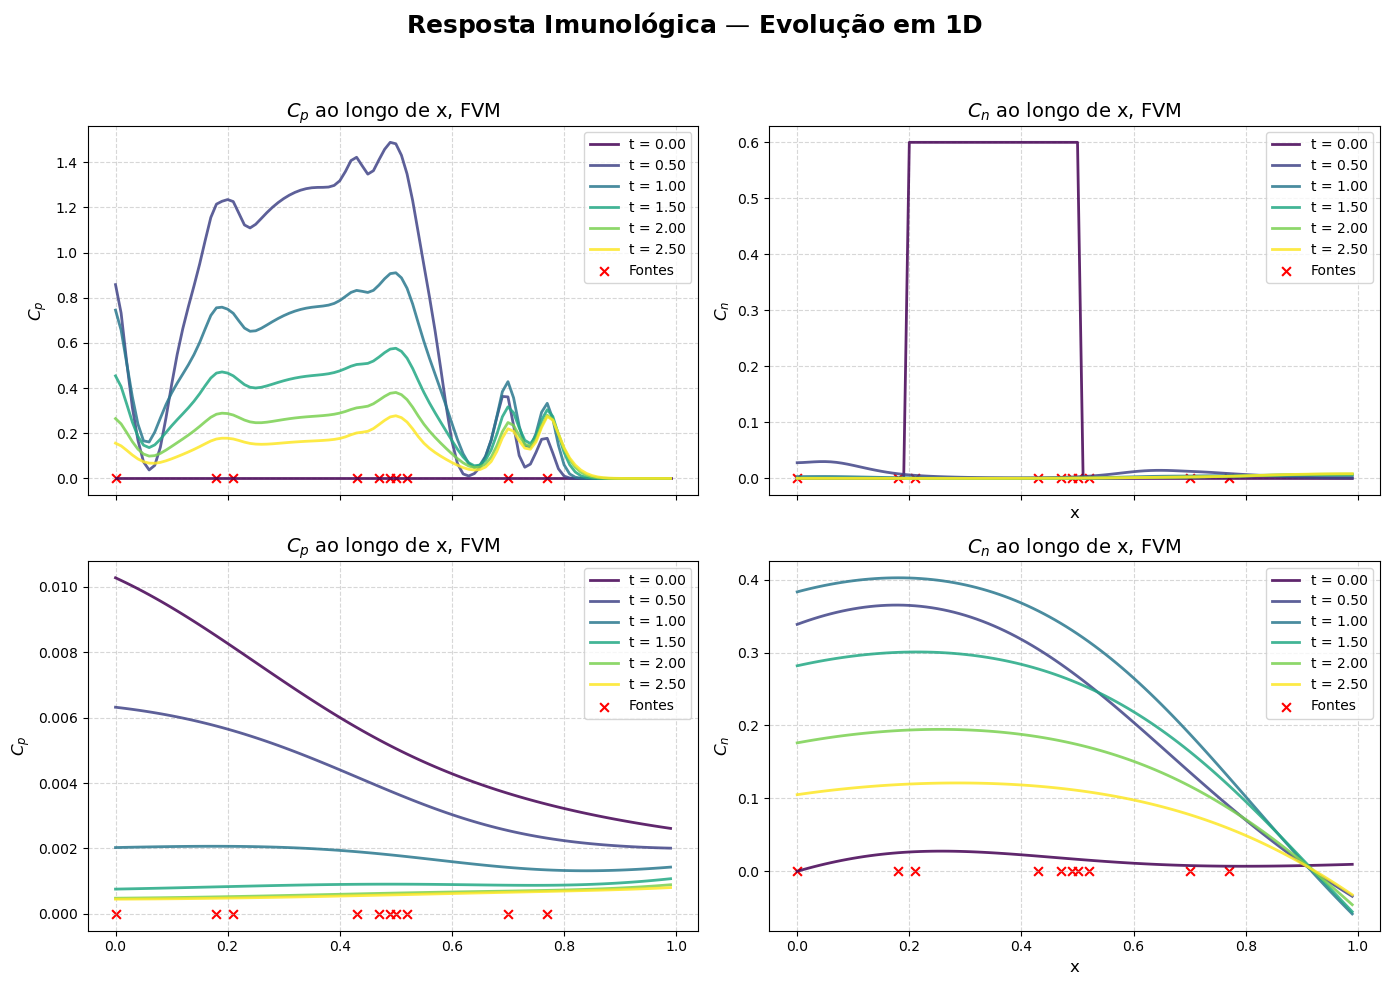

In [14]:
plot_comparison(
    size_t,
    size_x,
    t_dom,
    x_dom,
    Cp_target_np,
    Cl_target_np,
    Cp_pinn_np,
    Cl_pinn_np,
    leu_source_points[1],
)

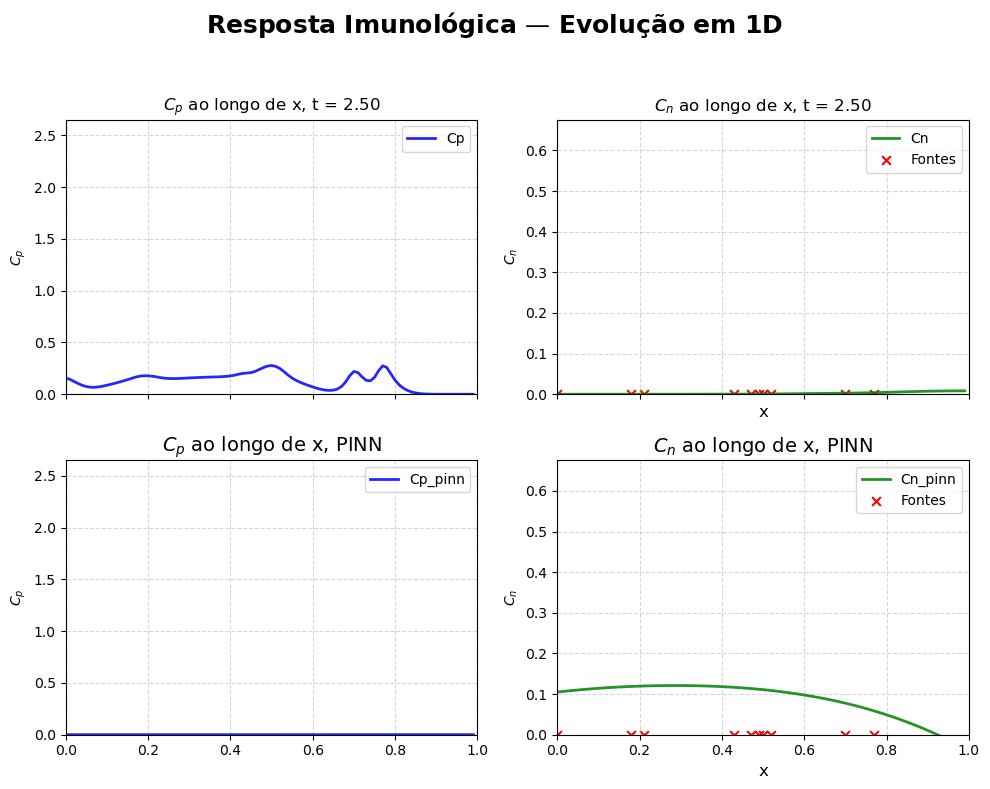

In [15]:
animate_1D_comparison(
    size_t,
    size_x,
    t_dom,
    x_dom,
    Cp_target_np,
    Cl_target_np,
    Cp_pinn_np,
    Cl_pinn_np,
    leu_source_points[1],
    (size_t - 1) // 100,
    150,
    name="evolucao_1D__pinn",
)